In [1]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import scanpy as sc
import squidpy as sq

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from adjustText import adjust_text

In [3]:
sc.set_figure_params(vector_friendly=True, dpi_save=300) 
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams.update({
    'pdf.fonttype': 42, 
    'ps.fonttype': 42
})

In [9]:
cosmx = sc.read_h5ad("./Data/cosmx_human_nsclc_clustered.h5ad")

In [7]:
sc.pp.filter_cells(cosmx, min_genes=3)
sc.pp.filter_genes(cosmx, min_cells=3)

In [8]:
cosmx

AnnData object with n_obs × n_vars = 765771 × 960
    obs: 'sample', 'cell_type', 'niche', 'fov', 'cell_ID', 'patient', 'n_counts', '_scvi_batch', '_scvi_labels', 'cluster_20', 'cluster_3', 'cluster_8', 'n_genes'
    var: 'n_counts', 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cluster_20_colors', 'cluster_3_colors', 'cluster_8_colors', 'log1p', 'spatial_neighbors'
    obsm: 'RNA', 'X_cellcharter', 'X_scVI', '_scvi_extra_categorical_covs', 'protein', 'spatial'
    layers: 'counts'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [6]:
adata = cosmx[(cosmx.obs['sample']=='LUAD-9 R1')]
adata.obs['CellType'] = adata.obs['cell_type'].str.replace(r'tumor \d+', 'tumors', regex=True)
adata.uns['spatial'] = {s: {} for s in adata.obs['sample'].unique()}

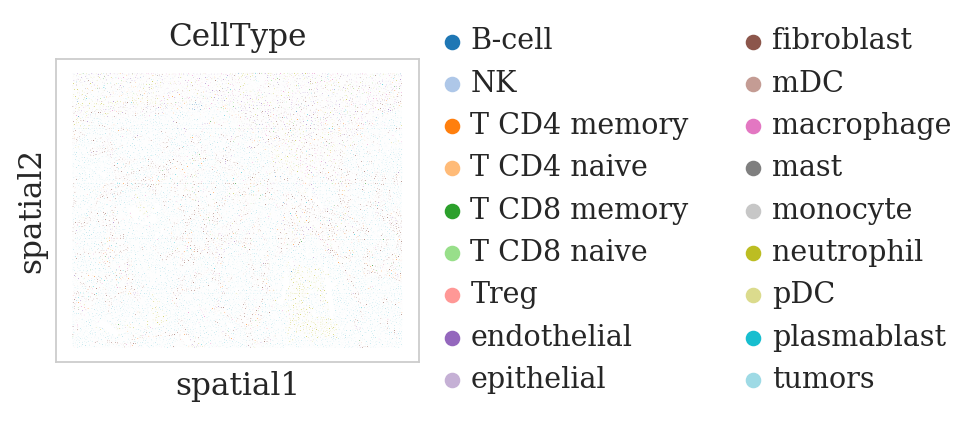

In [6]:
sq.pl.spatial_scatter(
    adata, 
    color=['CellType'],  
    size=30, 
    img=None,
    spatial_key='spatial',
    palette='tab20',
    figsize=(6,6),
    # save = './Figures/1_CellTypePlot.pdf'
)

In [12]:
adata.layers['counts'].max()

162.0

In [19]:
adata.obs.to_csv("./Data/obs.csv")

In [6]:
sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=True)

In [7]:
rows, cols = adata.obsp['spatial_distances'].nonzero()
values = adata.obsp['spatial_distances'].data

Spatial_Net = pd.DataFrame({
    'Cell1': rows,
    'Cell2': cols,
    'Distance': values
})

In [8]:
id_cell_trans = dict(zip(range(adata.shape[0]), np.array(adata.obs.index), ))
Spatial_Net['Cell1'] = Spatial_Net['Cell1'].map(id_cell_trans)
Spatial_Net['Cell2'] = Spatial_Net['Cell2'].map(id_cell_trans)

In [9]:
Spatial_Net['cluster'] = Spatial_Net['Cell2'].map(adata.obs['CellType'])

In [ ]:
# Spatial_Net.to_csv("./Data/spatial_net.csv")

In [7]:
Spatial_Net = pd.read_csv("./Data/spatial_net.csv")

In [7]:
Spatial_Net[Spatial_Net.Cell1 == "0-4"]

Unnamed: 0 Cell1    Cell2    Distance     cluster
0           0   0-4     97-4   84.023806  neutrophil
1           1   0-4     46-4   53.150729      tumors
2           2   0-4     47-4   48.877398      tumors
3           3   0-4  22572-4  127.141653      tumors
4           4   0-4  22581-4   69.426220    monocyte
5           5   0-4  22609-4   83.240615      tumors

In [8]:
spatial_net_df = Spatial_Net.pivot_table(index='Cell1', columns='cluster',fill_value=0, aggfunc='size')
spatial_net_df.index = spatial_net_df.index.astype(str)
spatial_net_df = spatial_net_df.div(spatial_net_df.sum(axis=1)+1e-6, axis=0)
spatial_net_df.columns

Index(['B-cell', 'NK', 'T CD4 memory', 'T CD4 naive', 'T CD8 memory',
       'T CD8 naive', 'Treg', 'endothelial', 'epithelial', 'fibroblast', 'mDC',
       'macrophage', 'mast', 'monocyte', 'neutrophil', 'pDC', 'plasmablast',
       'tumors'],
      dtype='object', name='cluster')

## Neighborhood heterogenety

In [10]:
import ROGUE as rge

In [11]:
rogue_list = {}
for i in adata.obs['CellType'].unique():
    intersect_cells =  spatial_net_df.index.intersection(adata[adata.obs.CellType==i,:].obs.index)
    spatial_net_df_subset = spatial_net_df.loc[intersect_cells,:]
    neigh_entropies = spatial_net_df_subset.apply(rge.neighborhoods_entropy, axis=0)
    rogue_list[i] = neigh_entropies
neig_entropy = pd.DataFrame(rogue_list).T

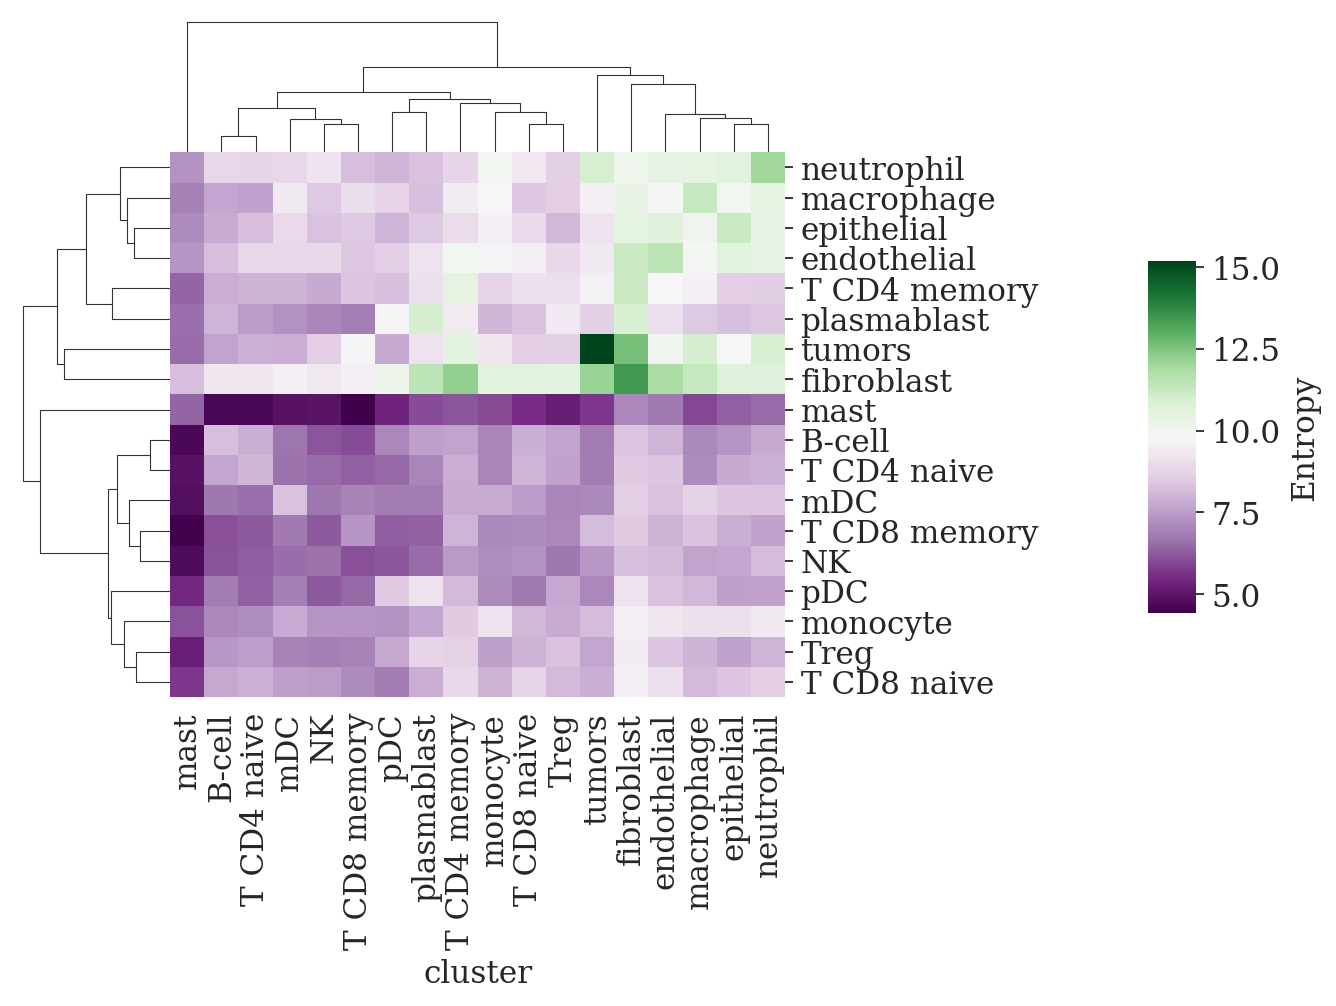

In [18]:
g = sns.clustermap(neig_entropy,col_cluster=True,row_cluster=True,cbar_kws={'label': 'Entropy'},
                   cmap='PRGn',
                   cbar_pos=(1.2, 0.3, 0.05, 0.4))
g.fig.set_size_inches(6, 5.5)
g.savefig('./Figures/2_clustermap_entropy.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Spatail distribution & Module functional annotation

In [7]:
import gseapy as gp

In [8]:
celltypes = adata.obs['CellType'].astype(str).unique()

theta_logit = {}
eta = {}
topic_words = {}
for cell_type in celltypes:
    print(cell_type)
    prefix = f"Results/{cell_type}/SIGMOD_"
    theta_logit[cell_type] = pd.read_csv(prefix+"theta_logit_denovo.csv", index_col=0)
    eta[cell_type] = pd.read_csv(prefix+"eta_denovo.csv", index_col=0)
    topic_words[cell_type] = pd.read_csv(prefix+"topicWords_denovo.csv", index_col=0).T

    theta_logit[cell_type].columns = [cell_type + str(i+1) for i in range(topic_words[cell_type].shape[1])]
    eta[cell_type].columns = [cell_type + str(i+1) for i in range(topic_words[cell_type].shape[1])]
    topic_words[cell_type].columns = [cell_type + str(i+1) for i in range(topic_words[cell_type].shape[1])]



tumors
epithelial
neutrophil
fibroblast
endothelial
T CD8 memory
B-cell
T CD4 memory
T CD4 naive
NK
monocyte
macrophage
plasmablast
Treg
T CD8 naive
mDC
pDC
mast


In [9]:
celltypes = adata.obs['CellType'].astype(str).unique()
for cl in celltypes:
    theta_logit_ct = theta_logit[cl]
    for i in range(theta_logit_ct.shape[1]):
        adata.obs.loc[theta_logit_ct.index,cl+str(i+1)] = theta_logit_ct.iloc[:,i]

print(adata.obs.columns[13:70])

Index(['tumors1', 'tumors2', 'tumors3', 'epithelial1', 'epithelial2',
       'neutrophil1', 'neutrophil2', 'fibroblast1', 'fibroblast2',
       'fibroblast3', 'endothelial1', 'endothelial2', 'T CD8 memory1',
       'T CD8 memory2', 'B-cell1', 'B-cell2', 'T CD4 memory1', 'T CD4 memory2',
       'T CD4 naive1', 'T CD4 naive2', 'NK1', 'NK2', 'monocyte1', 'monocyte2',
       'macrophage1', 'macrophage2', 'plasmablast1', 'plasmablast2', 'Treg1',
       'Treg2', 'T CD8 naive1', 'T CD8 naive2', 'mDC1', 'mDC2', 'pDC1', 'pDC2',
       'mast1', 'mast2'],
      dtype='object')


## Module spatial distributions

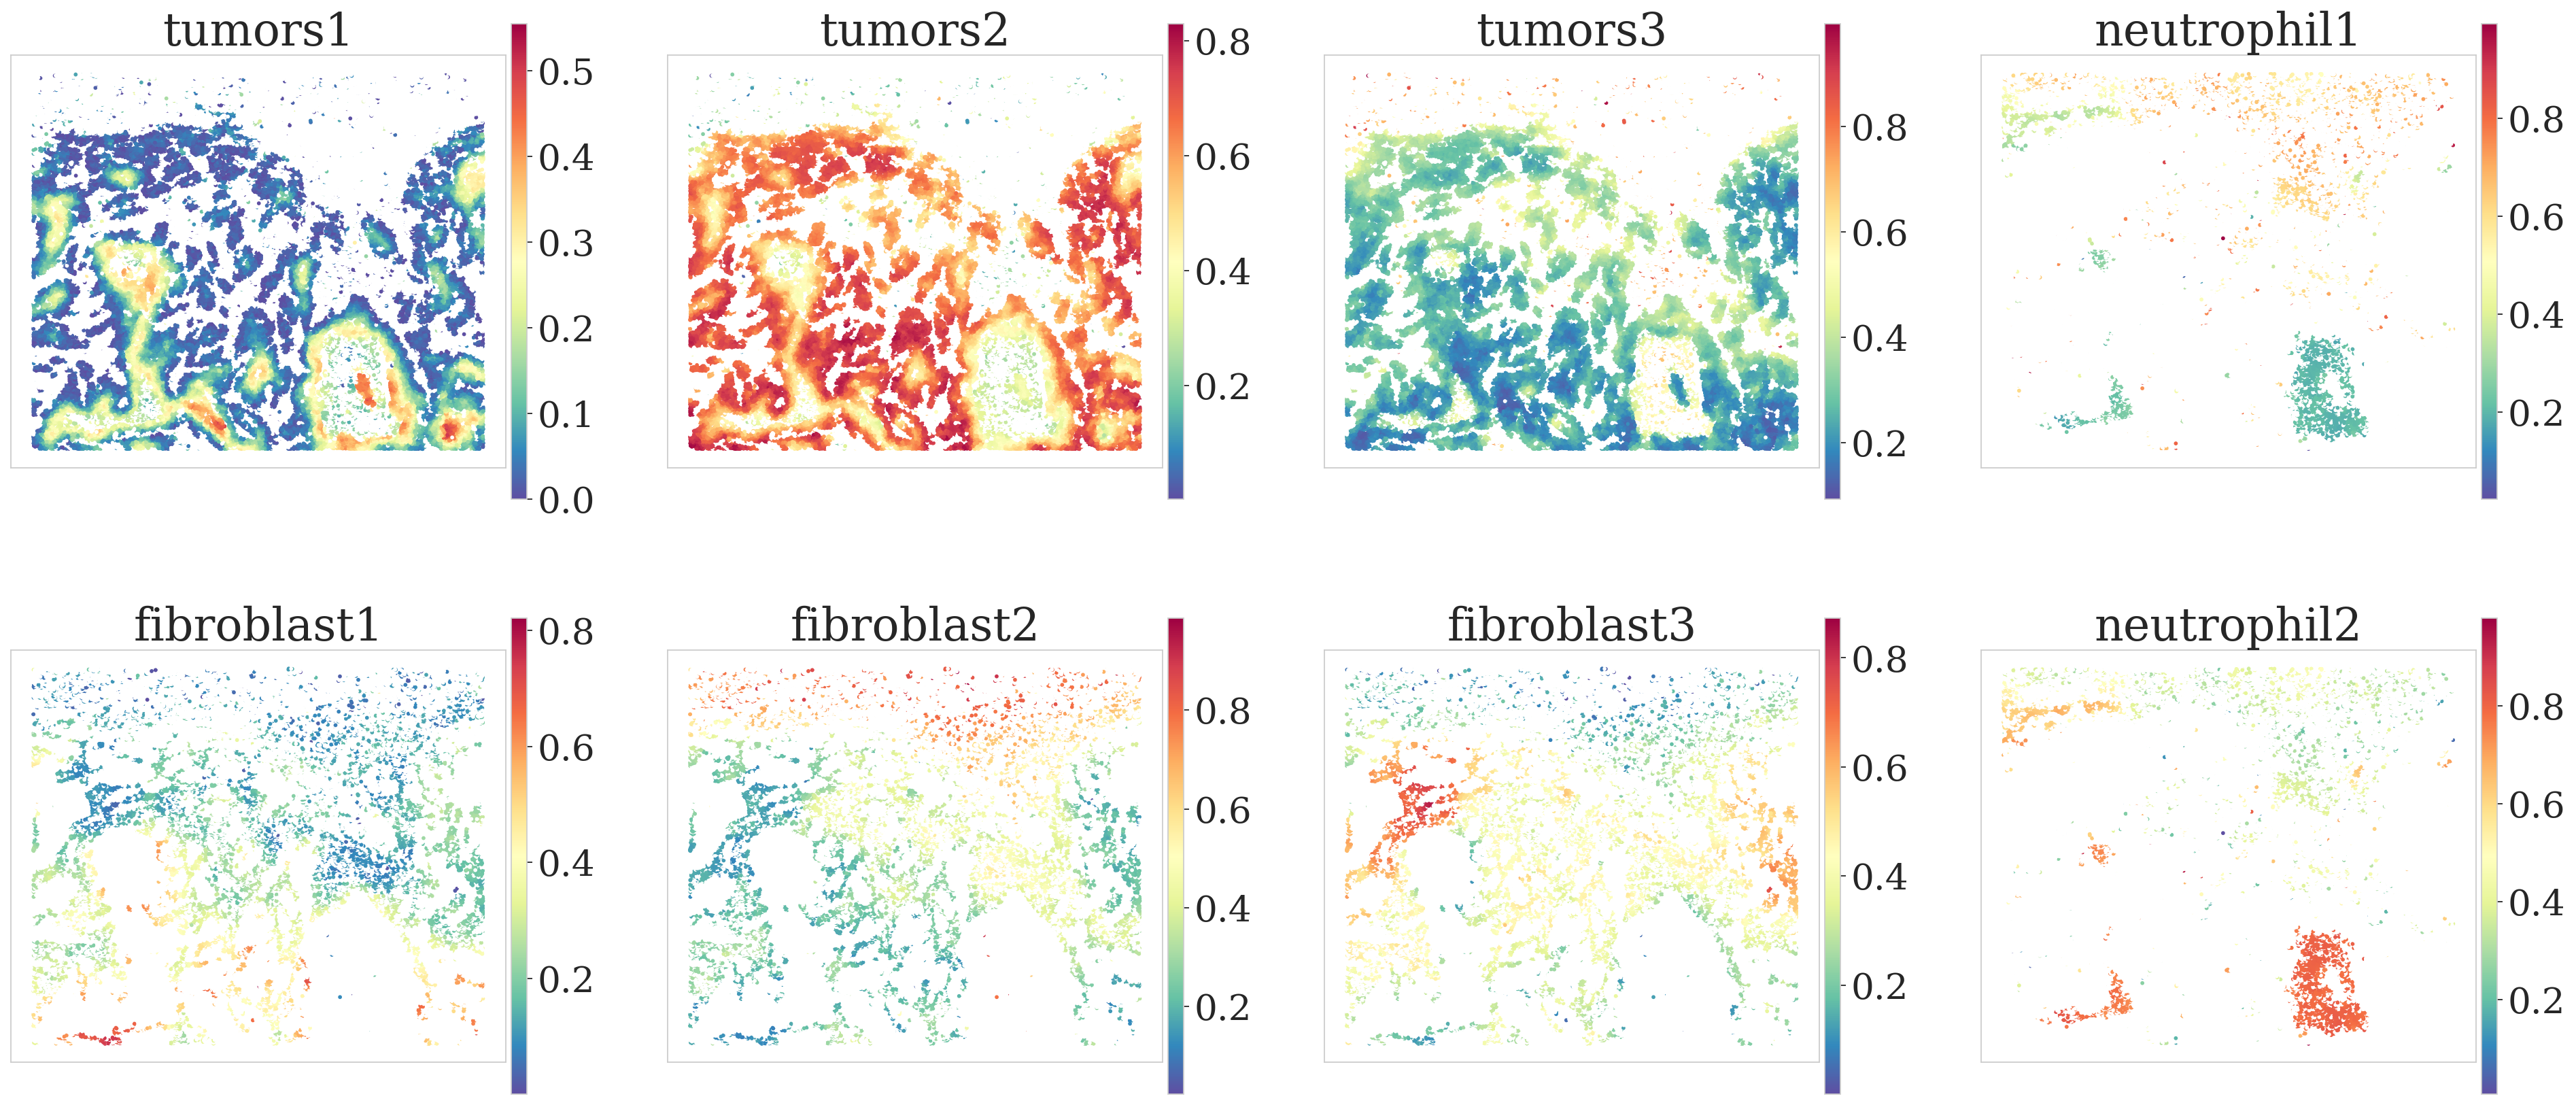

In [ ]:
cellsForplot = ['tumors1','tumors2', 'tumors3','neutrophil1',
                'fibroblast1','fibroblast2','fibroblast3','neutrophil2']

axs = sq.pl.spatial_scatter(
    adata,
    color=cellsForplot,
    cmap='Spectral_r',
    colorbar = True,
    size=10,
    shape=None,
    na_color="white",
    ncols=4,
    title=cellsForplot,
    legend_loc=False,
    return_ax=True,
    figsize=(6, 6),
)

for i, ax in enumerate(axs):
    if isinstance(ax, plt.Axes):
        if hasattr(ax, 'collections') and ax.collections:
            for collection in ax.collections:
                if hasattr(collection, 'colorbar') and collection.colorbar:
                    cbar = collection.colorbar

                    cbar.ax.tick_params(labelsize=24)
    ax.set_xlabel('')
    ax.set_ylabel('')

for ax, title in zip(plt.gcf().axes, cellsForplot):
    if hasattr(ax, 'set_title'):
        ax.set_title(title, fontsize=30)

plt.savefig('./Figures/3_1_tumor_module.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
cts = ['epithelial1', 'epithelial2','endothelial1', 'endothelial2', 
 'T CD8 memory1','T CD8 memory2', 'B-cell1', 'B-cell2', 
 'T CD4 memory1', 'T CD4 memory2','T CD4 naive1', 'T CD4 naive2', 
 'NK1', 'NK2', 'monocyte1', 'monocyte2',
 'macrophage1', 'macrophage2', 'plasmablast1', 'plasmablast2', 
 'Treg1','Treg2', 'T CD8 naive1', 'T CD8 naive2', 
 'mDC1', 'mDC2', 'pDC1', 'pDC2','mast1', 'mast2']

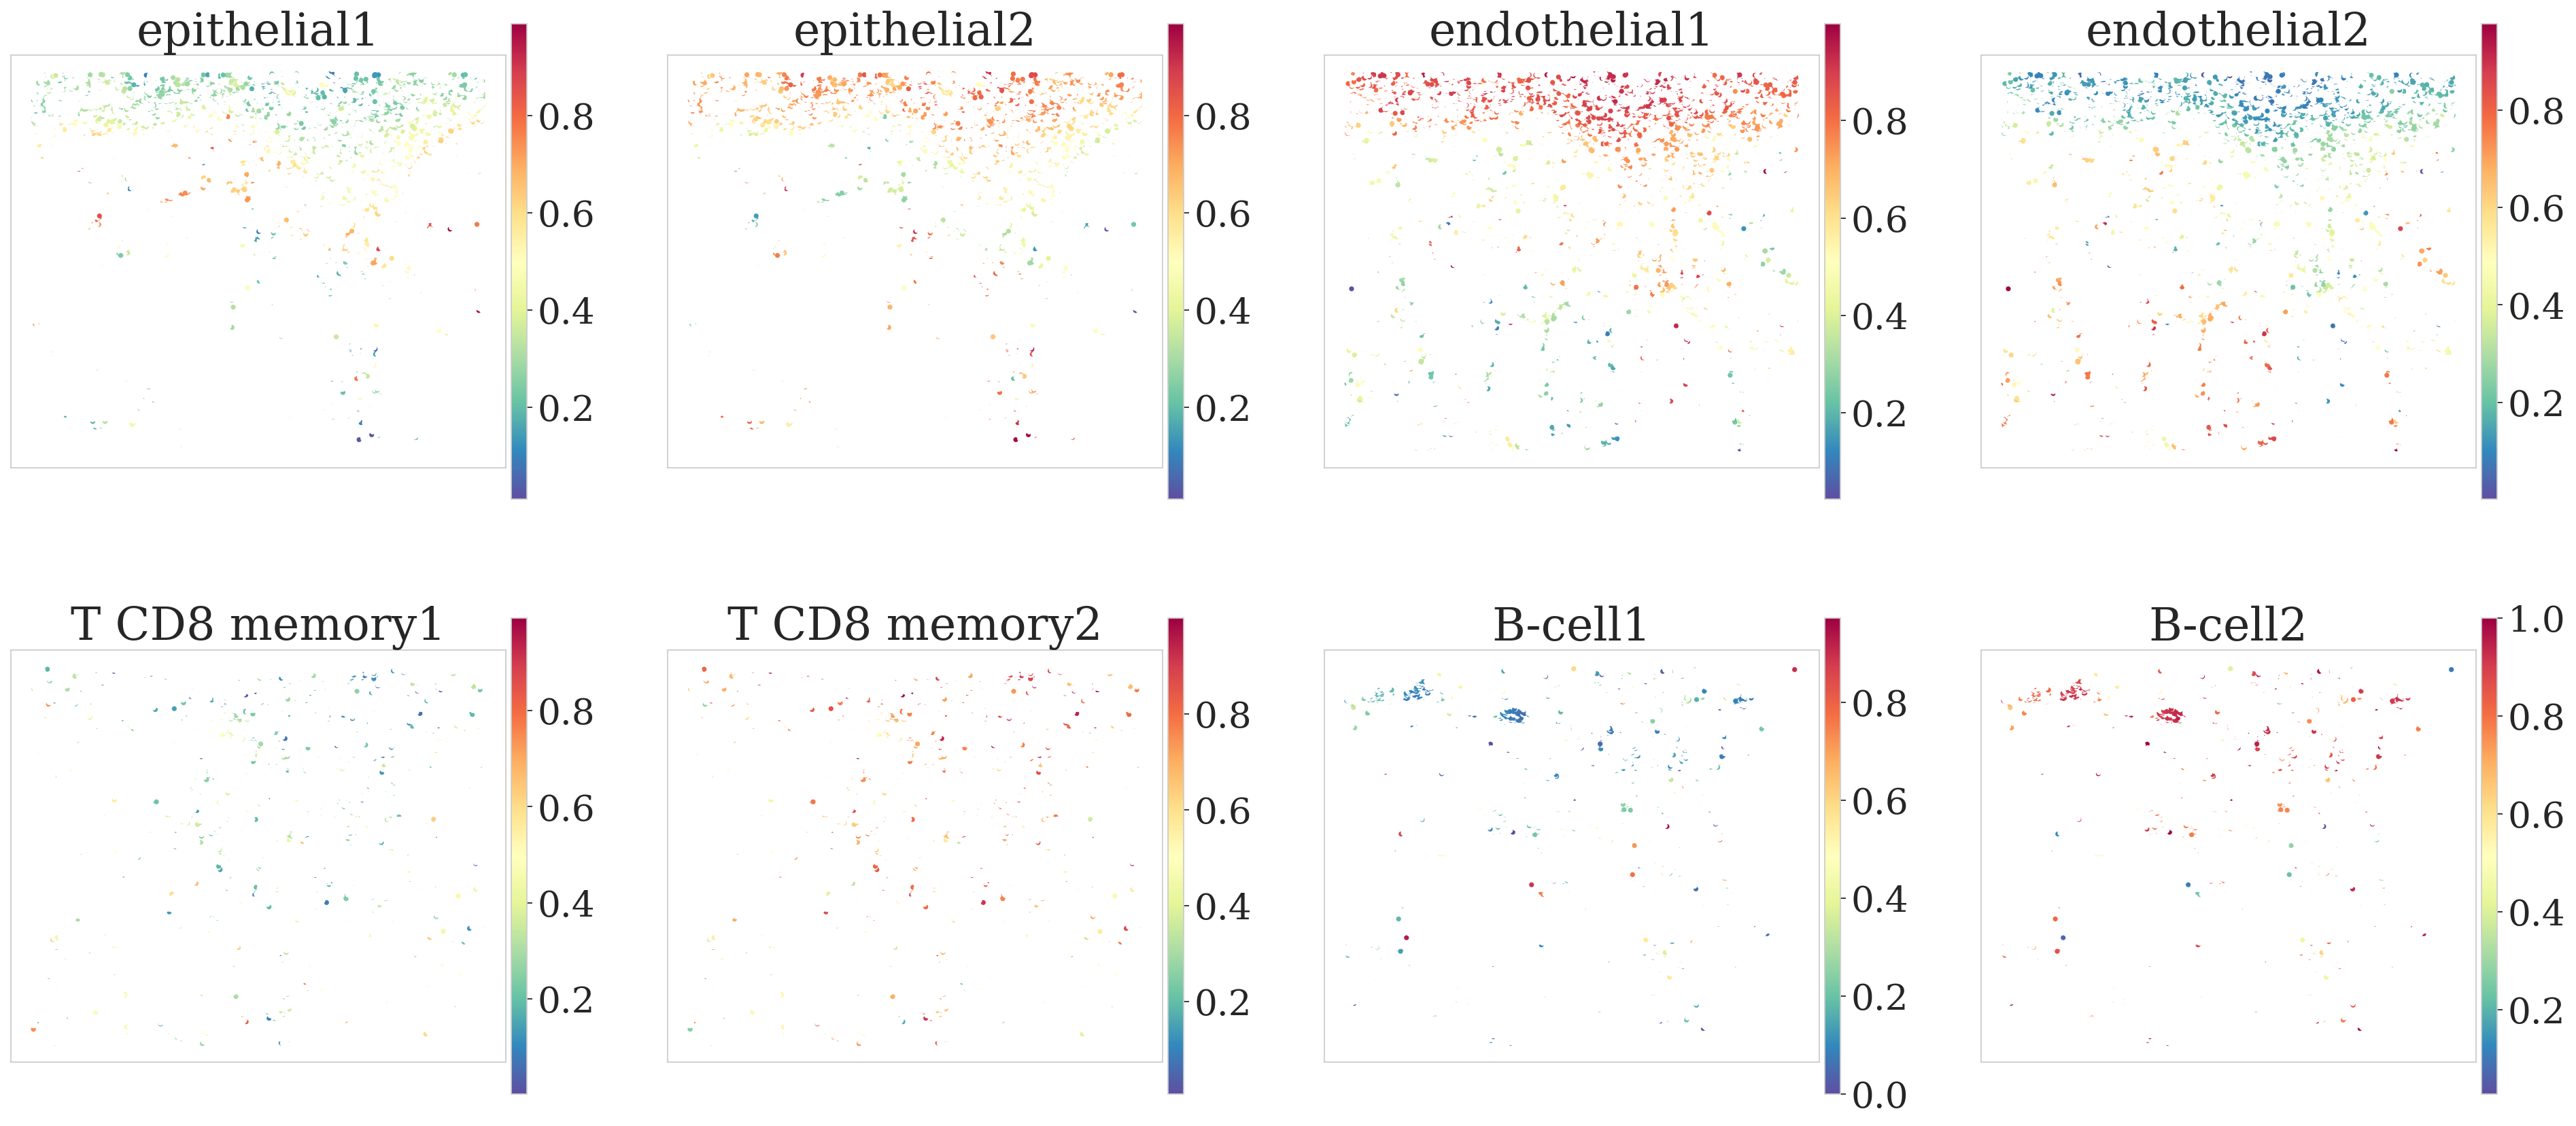

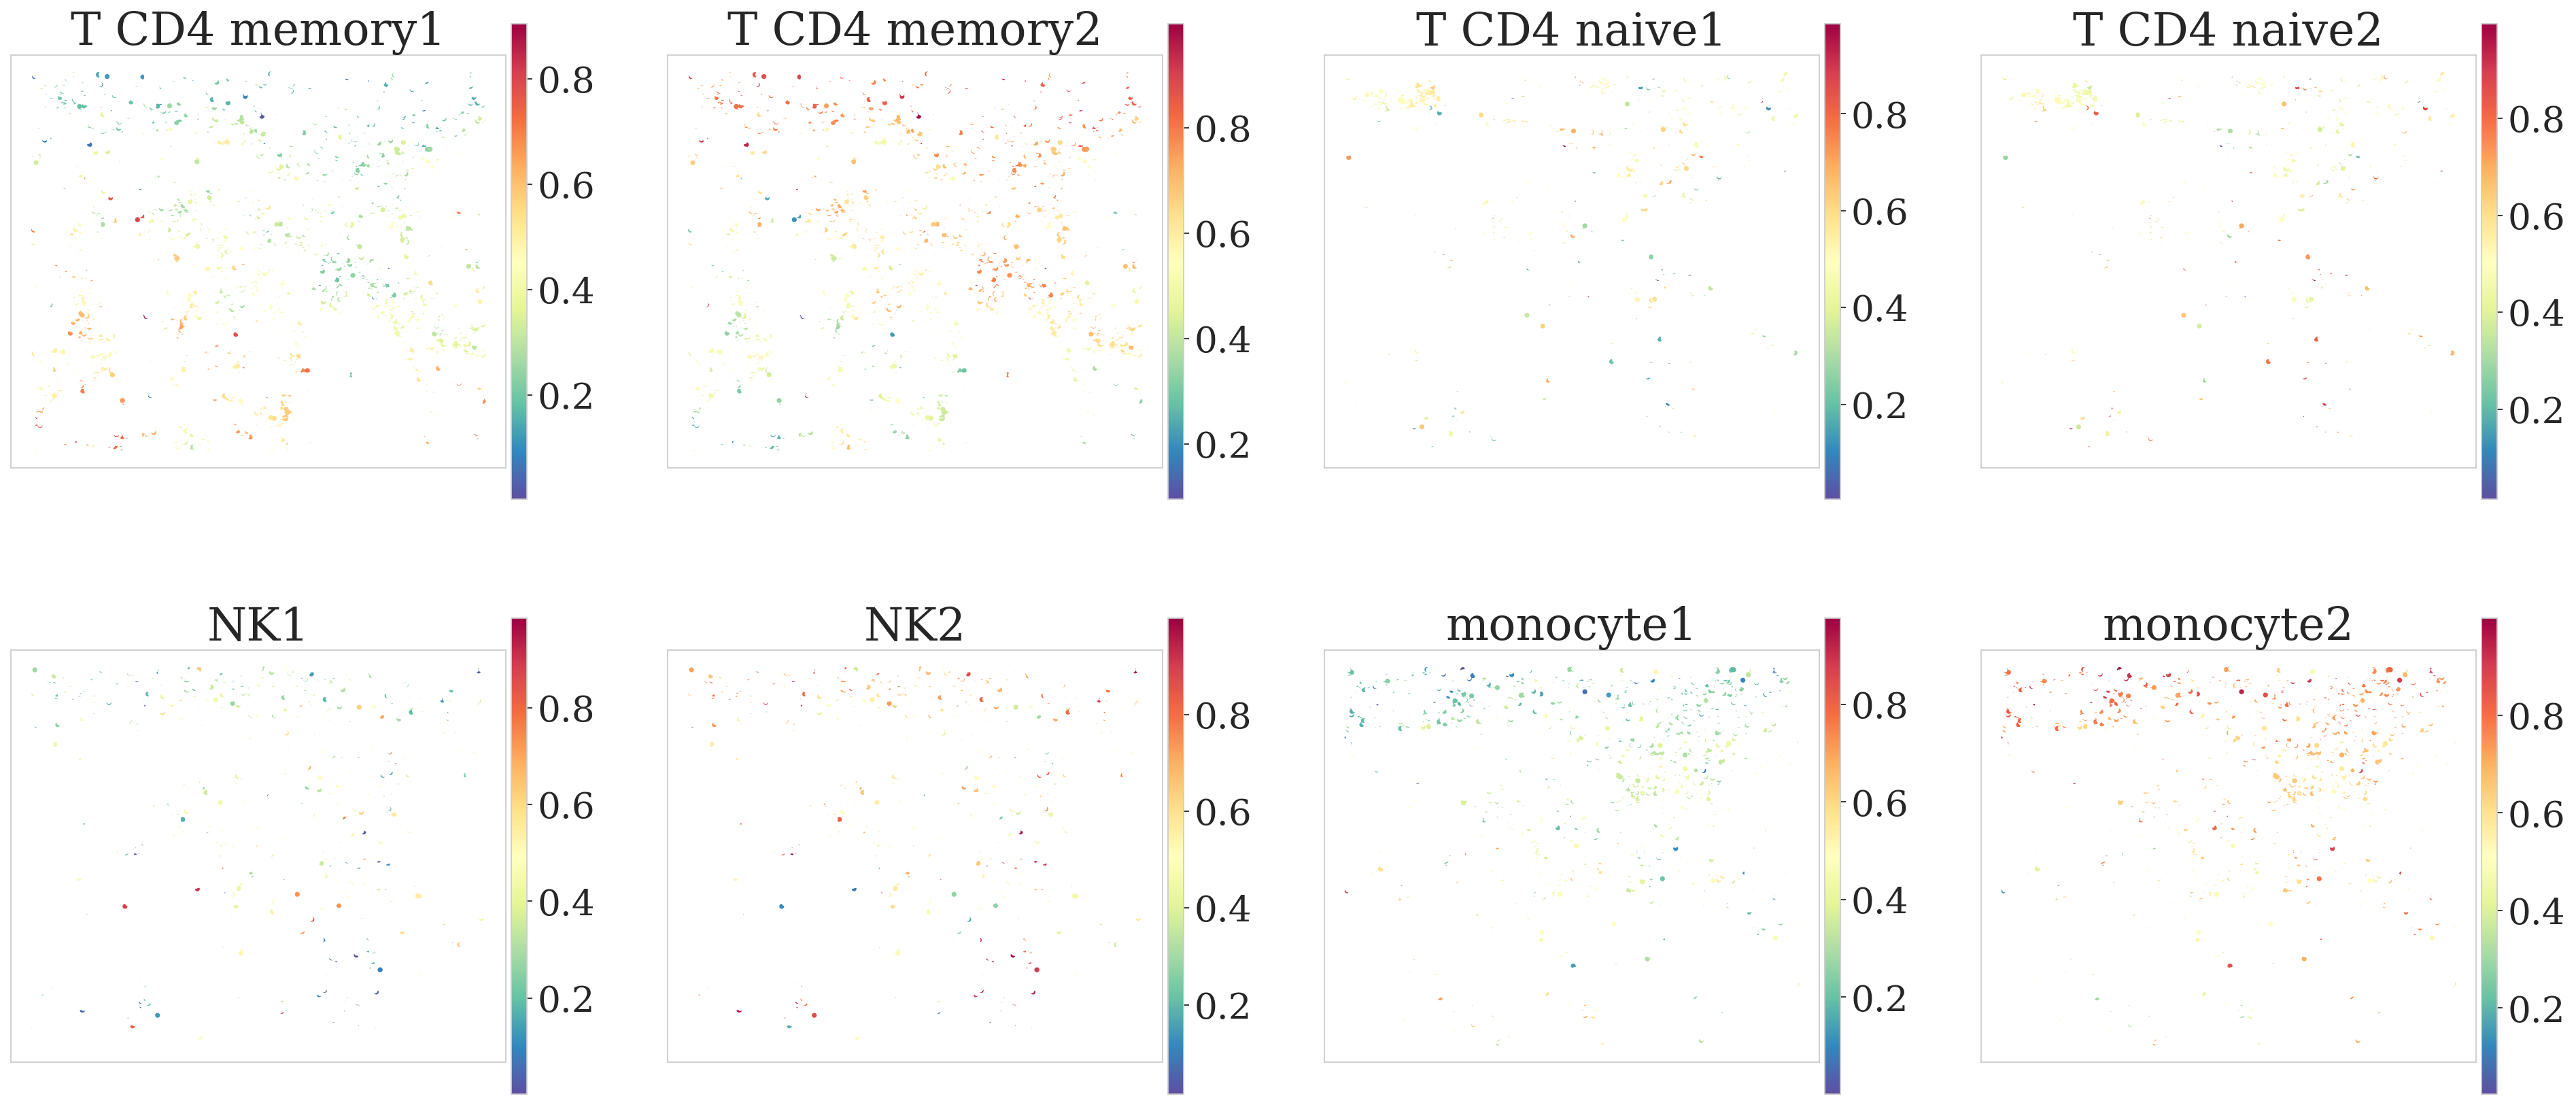

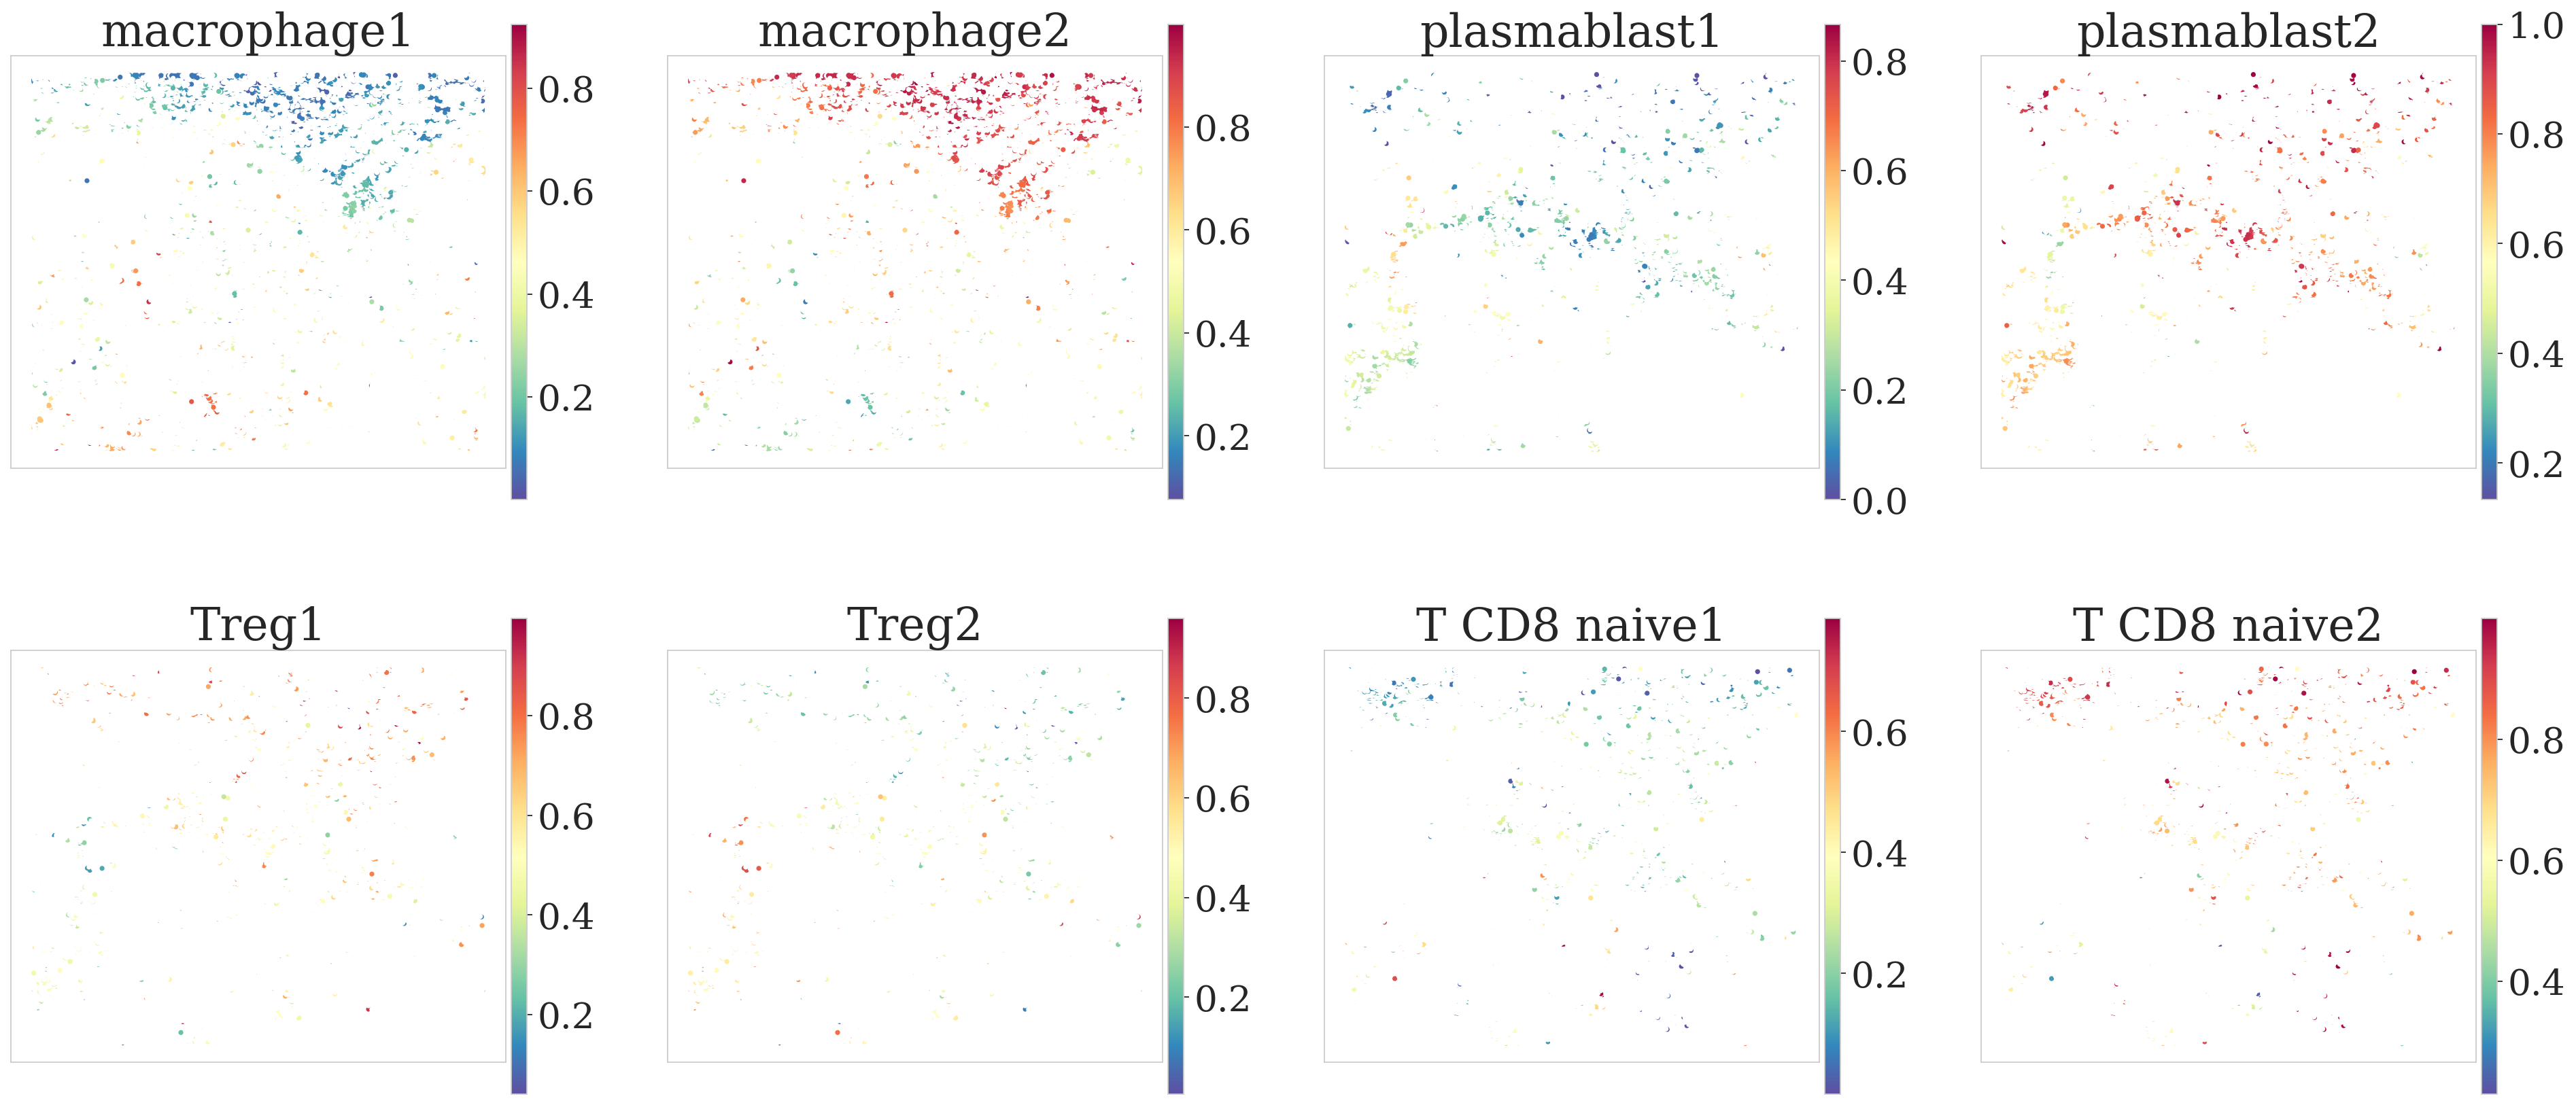

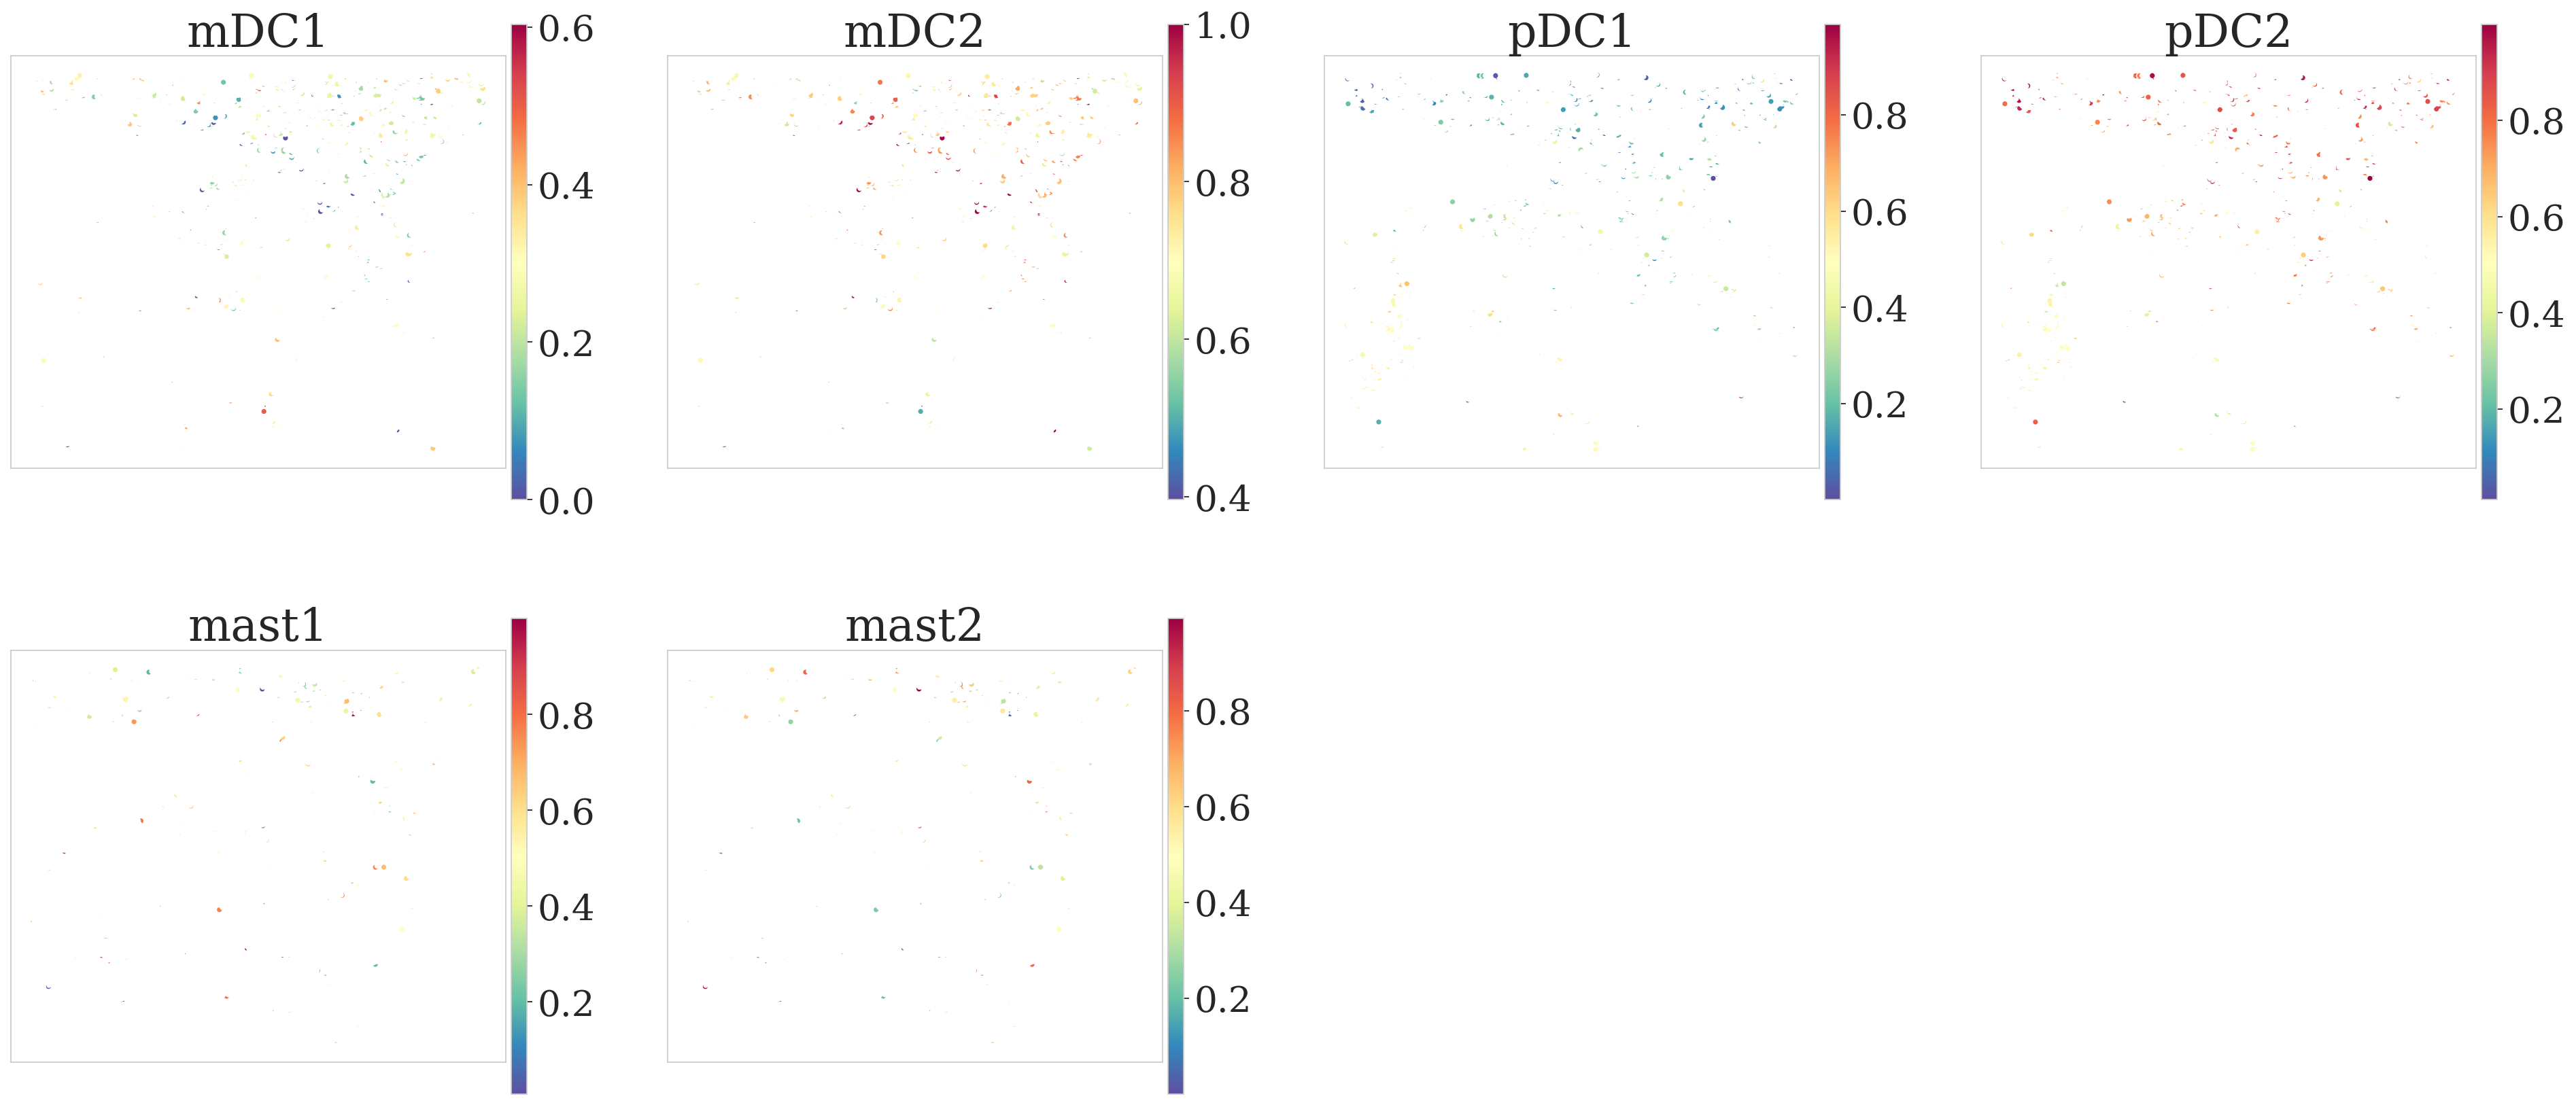

In [21]:
for j in range(0,30,8):

    cellsForplot = cts[j:j+8]

    axs = sq.pl.spatial_scatter(
        adata,
        color=cellsForplot,
        cmap='Spectral_r',
        colorbar = True,
        size=20,
        shape=None,
        na_color="white",
        ncols=4,
        title=cellsForplot,
        legend_loc=False,
        return_ax=True,
        figsize=(6, 6),
    )

    for i, ax in enumerate(axs):
        if isinstance(ax, plt.Axes):
            if hasattr(ax, 'collections') and ax.collections:
                for collection in ax.collections:
                    if hasattr(collection, 'colorbar') and collection.colorbar:
                        cbar = collection.colorbar
                        # cbar.ax.set_position([0 + 0.166*(i+1), 0.25, 0.02, 0.5])
                        cbar.ax.tick_params(labelsize=24)
        ax.set_xlabel('')
        ax.set_ylabel('')

    for ax, title in zip(plt.gcf().axes, cellsForplot):
        if hasattr(ax, 'set_title'):
            ax.set_title(title, fontsize=30)

    plt.savefig(f'./Figures/3_{j}_module.pdf', dpi=300, bbox_inches='tight')

## Module functional annotation

In [65]:
func_anno = {}
gene_sets = 'MSigDB_Hallmark_2020'

for ct,sigmod_beta in topic_words.items():
    gsea_results = {}

    for module in sigmod_beta.columns:
        gene_scores = sigmod_beta[module]
        gene_scores = gene_scores.dropna().sort_values(ascending=False)
        rnk = gene_scores.reset_index()
        rnk.columns = ['gene_name', 'score']
        pre_res = gp.prerank(rnk=rnk, gene_sets=gene_sets, processes=4, permutation_num=1000,min_size=1,
                            outdir=None, seed=42, verbose=False)
        
        gsea_results[module] = pre_res.res2d
        gsea_results[module]["Module"] = module
    gsea_results_df = pd.concat(gsea_results)
    # gsea_results_df = gsea_results_df[gsea_results_df["FDR q-val"]<1e-1]
    gsea_results_df_NES = pd.pivot(gsea_results_df,columns="Term",index="Module",values="NES")
    gsea_results_df_NES = gsea_results_df_NES.fillna(0)
    gsea_results_df_p = pd.pivot(gsea_results_df,columns="Term",index="Module",values="FDR q-val")
    gsea_results_df_p = gsea_results_df_p.fillna(1)
    gsea_results_df_NES = gsea_results_df_NES.loc[sigmod_beta.columns,].T
    gsea_results_df_p = gsea_results_df_p.loc[sigmod_beta.columns,].T
    conditions = [
        gsea_results_df_p < 1e-3,
        gsea_results_df_p < 1e-2,
        gsea_results_df_p < 5e-2,
        gsea_results_df_p > 5e-2,
    ]
    choices = [3,2, 1.5, 0]

    gsea_results_df_p_dis = pd.DataFrame(
        np.select(conditions, choices, default=np.nan),
        index=gsea_results_df_p.index,
        columns=gsea_results_df_p.columns
    )
    func_anno[ct] = gsea_results_df_NES,gsea_results_df_p_dis

2025-05-31 02:34:26,864 [WARNING] Duplicated values found in preranked stats: 0.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-05-31 02:34:27,187 [WARNING] Duplicated values found in preranked stats: 0.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


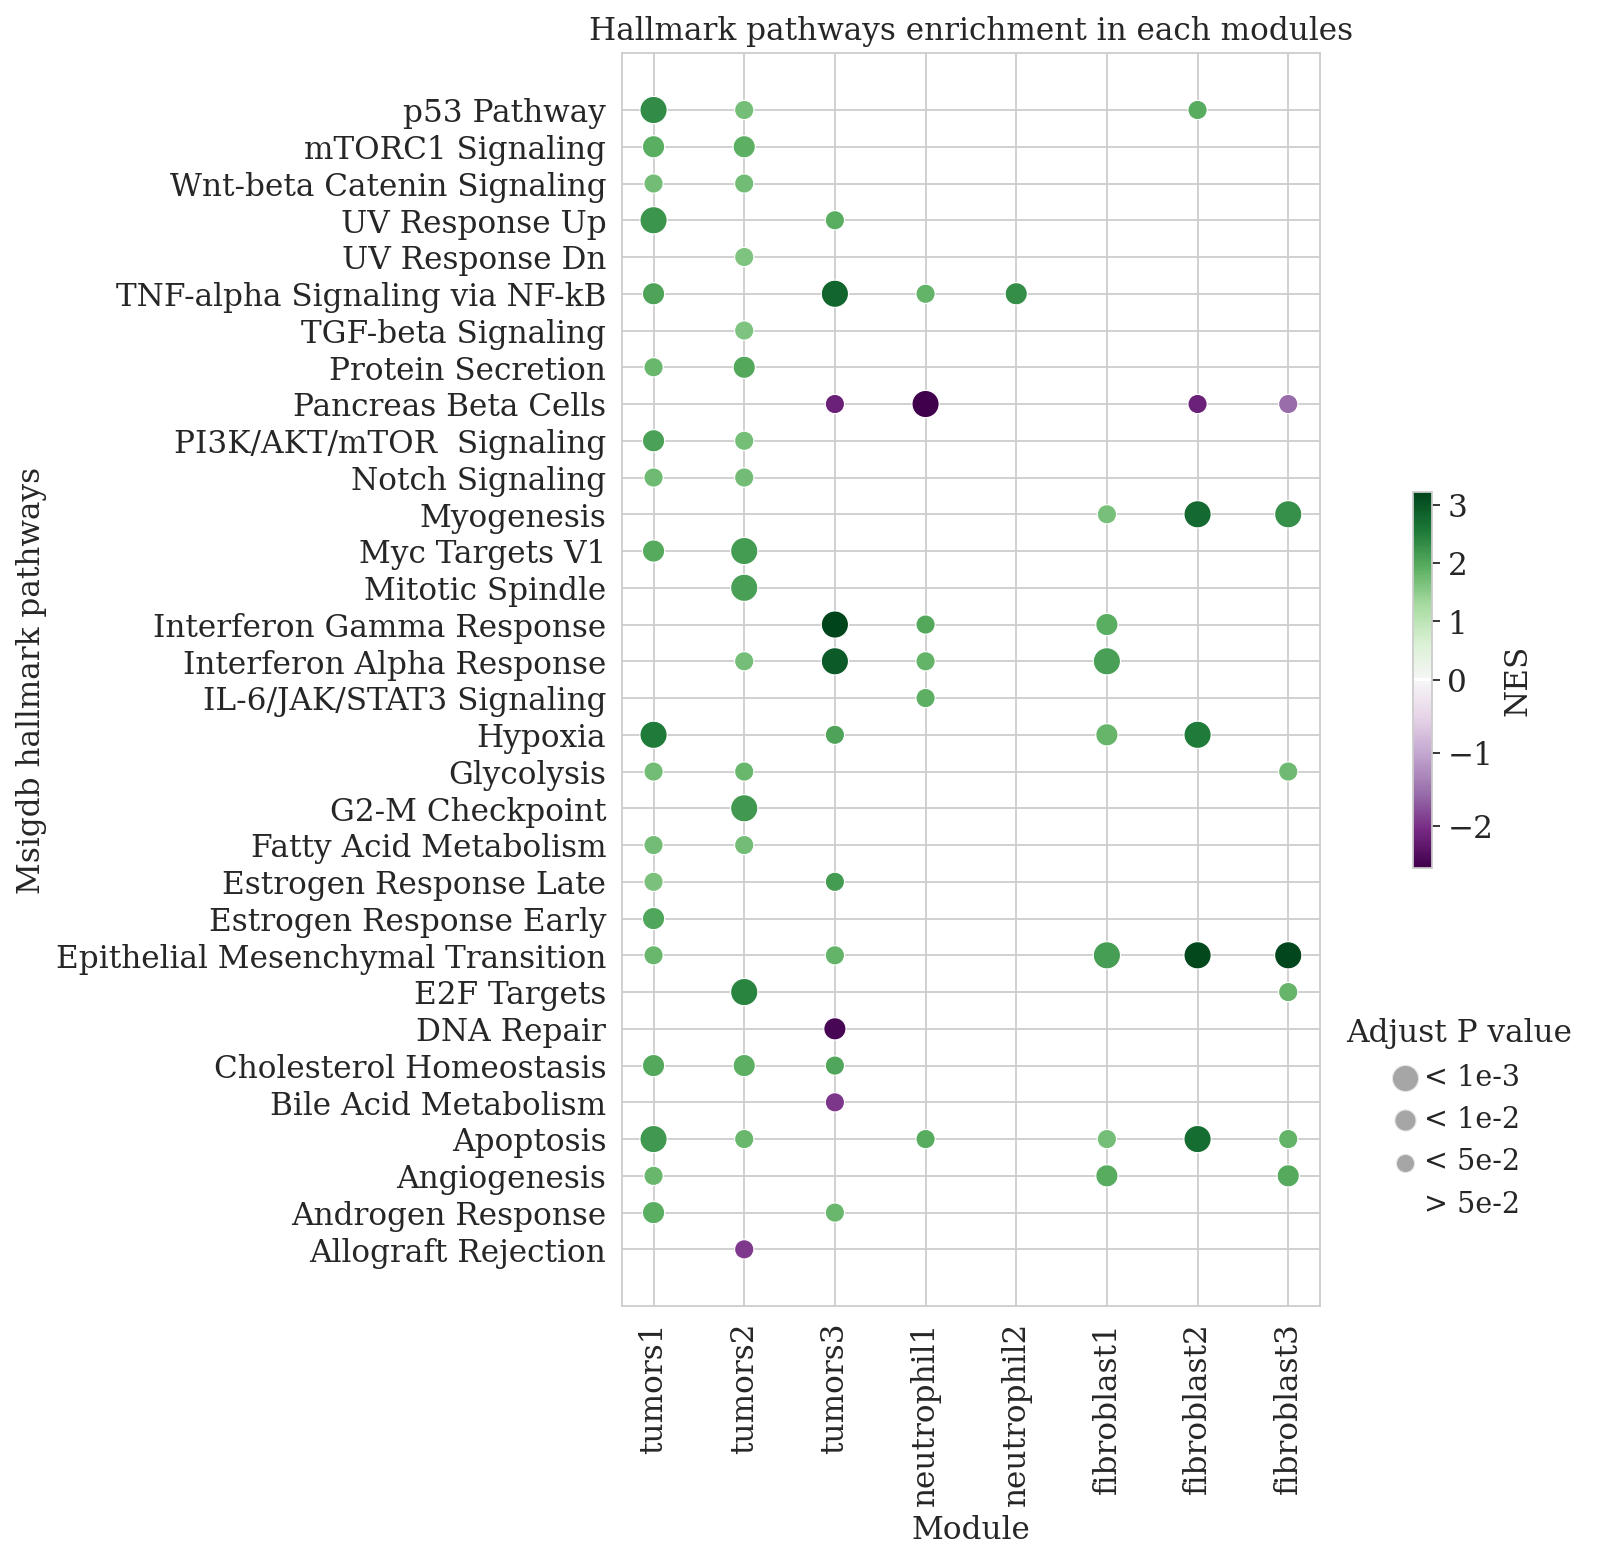

In [67]:
gsea_results_df_NES = pd.concat([func_anno["tumors"][0],func_anno["neutrophil"][0],func_anno["fibroblast"][0]],axis=1)
gsea_results_df_p_dis = pd.concat([func_anno["tumors"][1],func_anno["neutrophil"][1],func_anno["fibroblast"][1]],axis=1)

pathway_filter =  gsea_results_df_p_dis.sum(axis=1) != 0 
gsea_results_df_NES = gsea_results_df_NES[pathway_filter]
gsea_results_df_p_dis = gsea_results_df_p_dis[pathway_filter]

plt.figure(figsize=(10, 10))
group2_names = gsea_results_df_NES.index
group1_names = gsea_results_df_NES.columns

x, y = np.meshgrid(group1_names, group2_names)

x = x.flatten()
y = y.flatten()
exp_values = gsea_results_df_NES.values.flatten()
percent_values = gsea_results_df_p_dis.values.flatten()


### set color midpoint = 0
# Create a custom colormap based on PRGn, with 0 mapped to white
cmap = plt.cm.PRGn  # Get the original PRGn colormap
colors = cmap(np.linspace(0, 1, 256))  # Get the colormap's colors
# Modify the color at the midpoint (0) to white
midpoint = 128  # Assuming 256 colors, midpoint is around 128
colors[midpoint-1:midpoint+1] = [1, 1, 1, 1]  # Set to white (RGBA)
# Create a new colormap
custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_PRGn', colors)
# Normalize the data to map to the colormap, ensuring 0 is at the midpoint
norm = mcolors.TwoSlopeNorm(vmin=exp_values.min(), vcenter=0, vmax=exp_values.max())
#### 

scatter = plt.scatter(x, y, c=exp_values, s=percent_values*50, cmap=custom_cmap,norm=norm,
                       alpha=1, edgecolors="w", linewidth=0.5)

plt.colorbar(scatter, label='NES',pad=0.1,shrink=0.3)

legend_sizes = [3,2,1.5,0]
legend_sizes_scaled = [size * 50 for size in legend_sizes]
legend_labels = ["< 1e-3",
                 "< 1e-2",
                 "< 5e-2",
                 "> 5e-2",]

for size, scaled_size, label in zip(legend_sizes, legend_sizes_scaled, legend_labels):
    plt.scatter([], [], s=scaled_size, c='gray', alpha=0.7, edgecolors="w", label=label)

plt.legend(title='Adjust P value', loc='center left', bbox_to_anchor=(1.00, 0.15), frameon=False)

plt.xlabel('Module')
plt.ylabel('Msigdb hallmark pathways')
plt.title('Hallmark pathways enrichment in each modules')

plt.xticks(np.arange(len(group1_names)), group1_names, rotation=90)
plt.yticks(np.arange(len(group2_names)), group2_names)

plt.tight_layout()
plt.savefig("Figures/4_1_Tumor_Module_.pdf",dpi=300)
plt.show()

### Cross Cell state Analysis

In [10]:
import sys
sys.path.append("..")

from SIGMOD import SIGMOD_CCI as cci
from SIGMOD import SIGMOD_plot as sigmod_plot

In [70]:
import importlib
importlib.reload(cci)

<module 'SIGMOD.SIGMOD_CCI' from '/home/liuchang/3.0_Result/4.0_NGDeonv/0315/LUAD/../SIGMOD/SIGMOD_CCI.py'>

In [11]:
celltypes = adata.obs['CellType'].astype(str).unique()

results = cci.compute_correlations(theta_logit, eta, celltypes, Spatial_Net,0.7)

total_interactions = cci.construct_total_interactions(results, celltypes)

In [11]:
colors = [
    # tumors (黄色系)
    "#E6AB02", "#FFFF99", "#FFED6F", #"#DFC27D", "#F6E8C3",
    # epithelial (青绿色系)
    "#48D1CC", "#99CCCC",
    # neutrophil (紫色系)
    "#6A3D9A", "#9933CC", #"#CC99FF",
    # fibroblast (绿色系)
    "#1A9850", "#66C2A5", "#ABDDA4",# "#66BD63",
    # endothelial (蓝色系)
    "#00BFFF", "#87CEFA",
    # T CD8 memory (红色系)
    "#D6604D", "#9E0142",
    # B-cell (紫红色系)
    "#DE77AE", "#EE82EE",
    # T CD4 memory (橙色系)
    "#E08214", "#FDC086",# "#FF7F00",
    # T CD4 naive (橙黄色系)
    "#FDCDAC", "#F1E2CC",
    # NK (粉红色系)
    "#F4CAE4", "#FF00CC",
    # monocyte (深橙色系)
    "#B15928", "#8C510A",
    # macrophage (浅橙色系)
    "#FBB4AE", "#DFC27D",# "#F1E2CC",
    # plasmablast (深紫色系)
    "#5E4FA2", "#40004B",# "#B2ABD2",
    # Treg (深红色系)
    "#9E0142", "#FF33CC",
    # T CD8 naive (浅红色系)
    "#FBB4AE", "#F4CAE4",
    # mDC (蓝色系)
    "#6495ED", "#D1E5F0",
    # pDC (灰蓝色系)
    "#8DA0CB", "#B3CDE3",
    # mast (绿色系)
    "#66BD63", "#99CCCC"
]

celltypes = [
    "tumors1", "tumors2", "tumors3", #"tumors4", "tumors5",
    "epithelial1", "epithelial2",
    "neutrophil1", "neutrophil2", #"neutrophil3",
    "fibroblast1", "fibroblast2", "fibroblast3", #"fibroblast4",
    "endothelial1", "endothelial2",
    "T CD8 memory1", "T CD8 memory2",
    "B-cell1", "B-cell2",
    "T CD4 memory1", "T CD4 memory2",# "T CD4 memory3",
    "T CD4 naive1", "T CD4 naive2",
    "NK1", "NK2",
    "monocyte1", "monocyte2",
    "macrophage1", "macrophage2", #"macrophage3",
    "plasmablast1", "plasmablast2",# "plasmablast3",
    "Treg1", "Treg2",
    "T CD8 naive1", "T CD8 naive2",
    "mDC1", "mDC2",
    "pDC1", "pDC2",
    "mast1", "mast2"
]

node_color_map = {}
for celltype, color in zip(celltypes,colors):
    node_color_map[celltype] = color

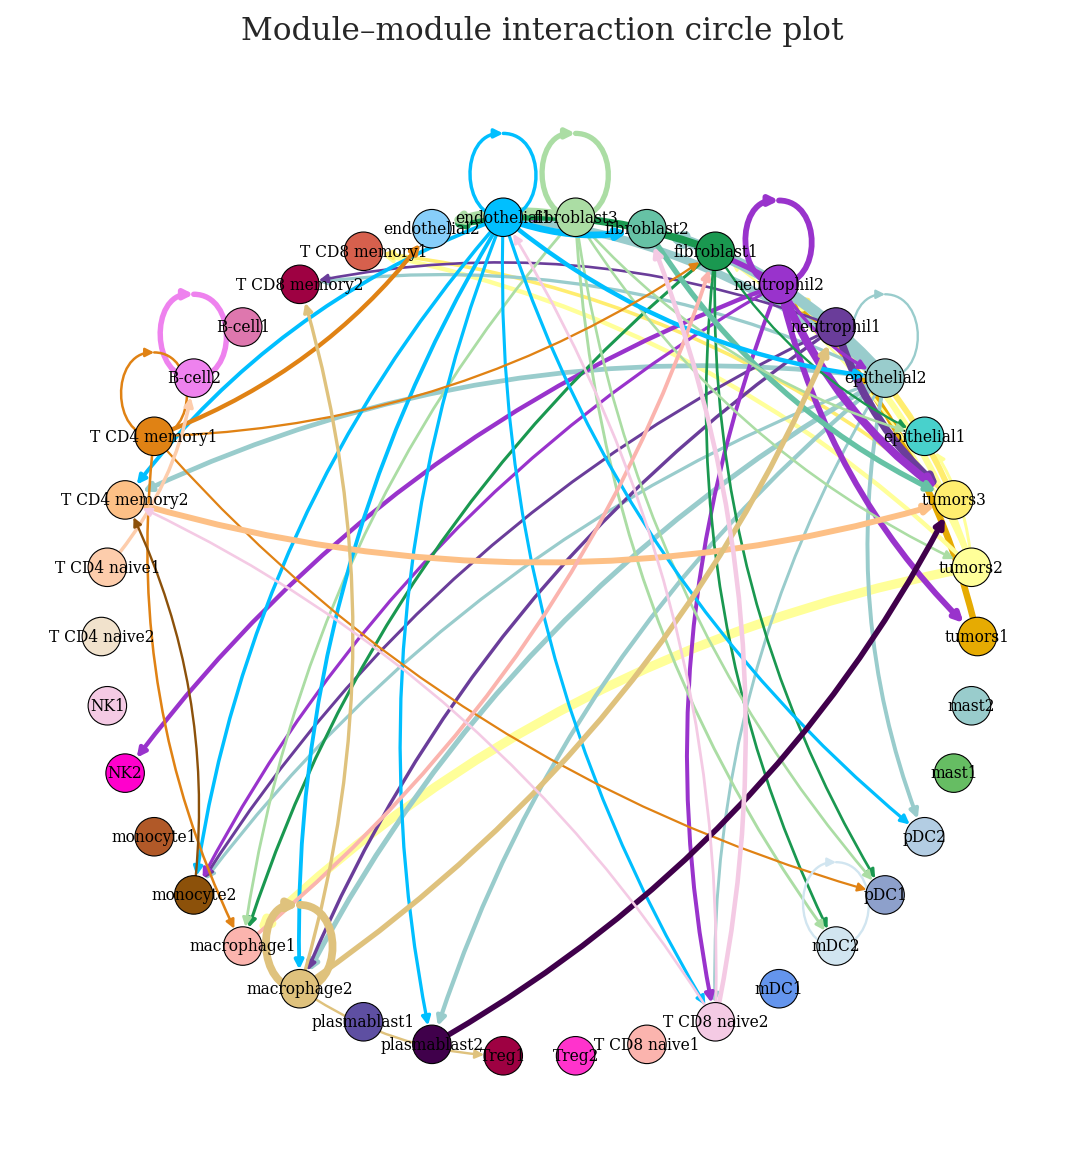

In [27]:
sigmod_plot.plot_circle_interactions(total_interactions.T,node_color_map,threshold = 0.05,
                                     edge_cmap="Reds",max_width=5,min_width=1,
                                     node_size=300,font_size=7,figsize = (7,7.5),
                                     file_name="Figures/5_1_TotalInteraction.pdf")

In [35]:
## Incoming and outcoming 
ingoing = total_interactions.sum(axis=1)
outgoing = total_interactions.sum(axis=0)

ingoing = pd.DataFrame(ingoing,columns=["incoming"])
outgoing = pd.DataFrame(outgoing,columns=["outgoing"])
ingoing["Module"] = ingoing.index
outgoing["Module"] = outgoing.index
in_out = ingoing.merge(outgoing,on = ["Module"])



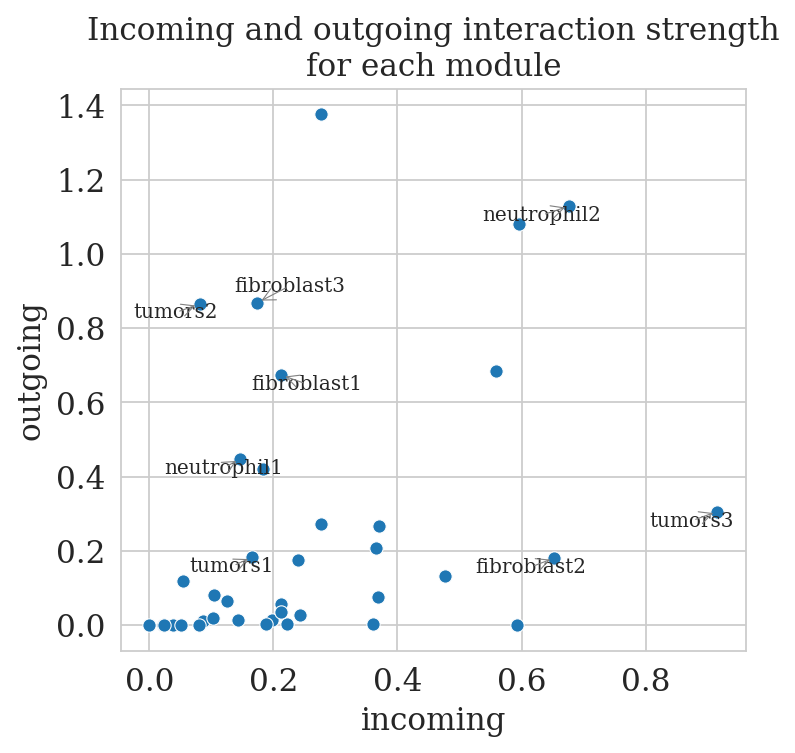

In [39]:
df = in_out[in_out["Module"].str.contains("tumors|fibroblast|neutrophil")]

plt.figure(figsize=(5, 5))
sns.scatterplot(data=in_out, x='incoming', y='outgoing')

texts = []
for i, row in df.iterrows():
    text = plt.text(
        row['incoming'], 
        row['outgoing'],
        row['Module'],
        fontsize=9,
        ha='center',
        va='center'
    )
    texts.append(text)

adjust_text(
    texts,
    arrowprops=dict(arrowstyle='->', color='gray', lw=0.5),
    expand_points=(1.2, 1.2),
    expand_text=(1.2, 1.2),
    force_points=0.5,
    force_text=0.5
)

plt.title('Incoming and outgoing interaction strength\nfor each module')
plt.tight_layout()
plt.savefig("Figures/4_2_interaction_strength.pdf",dpi=300)
plt.show()

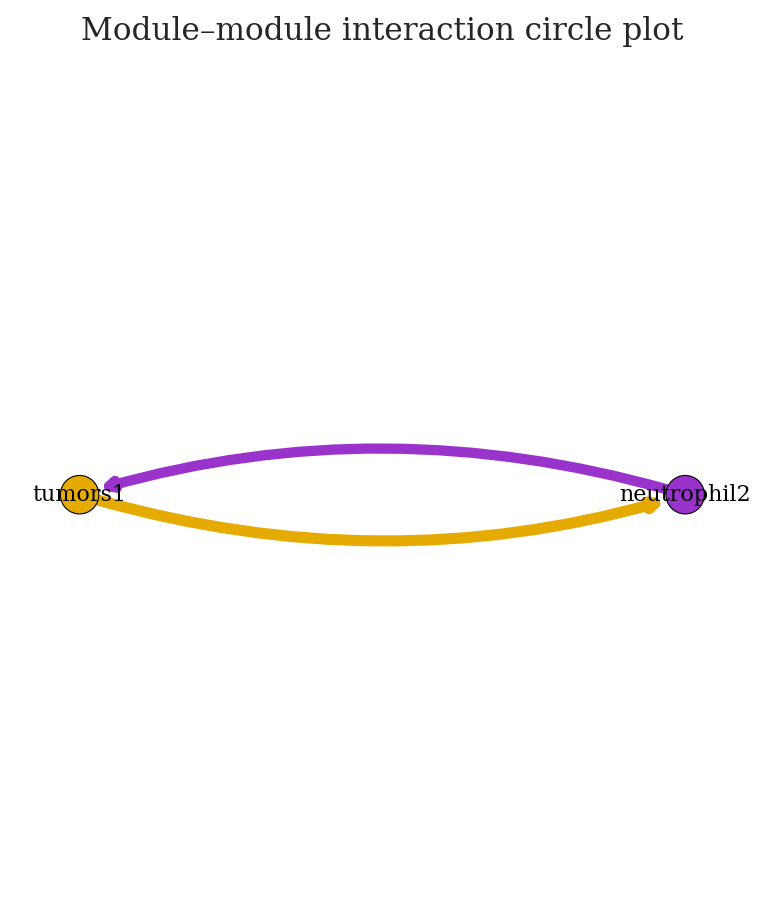

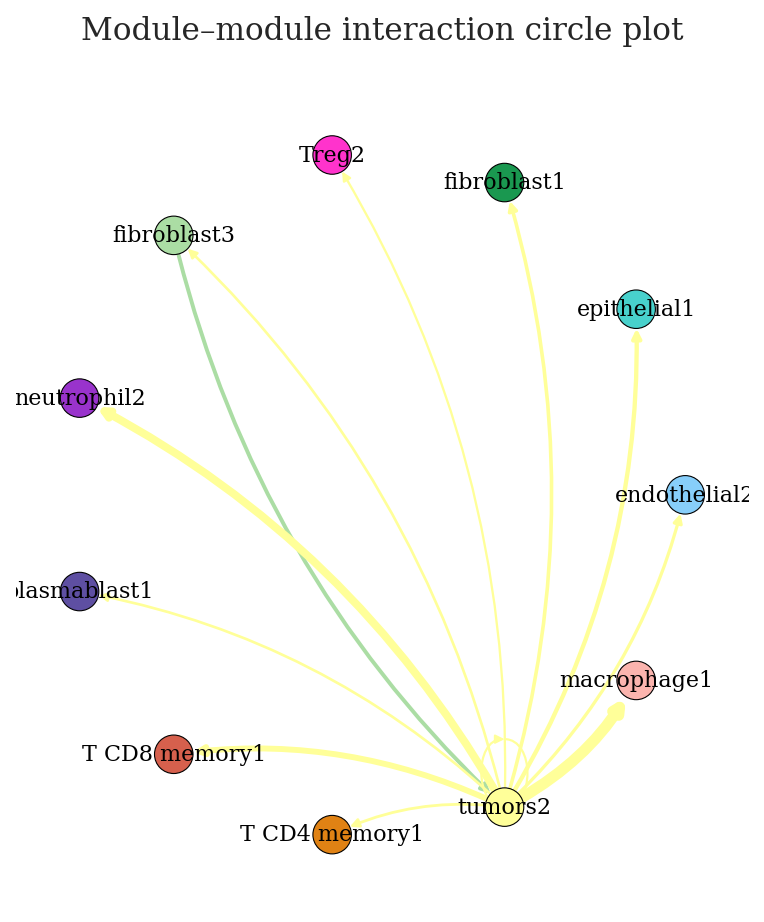

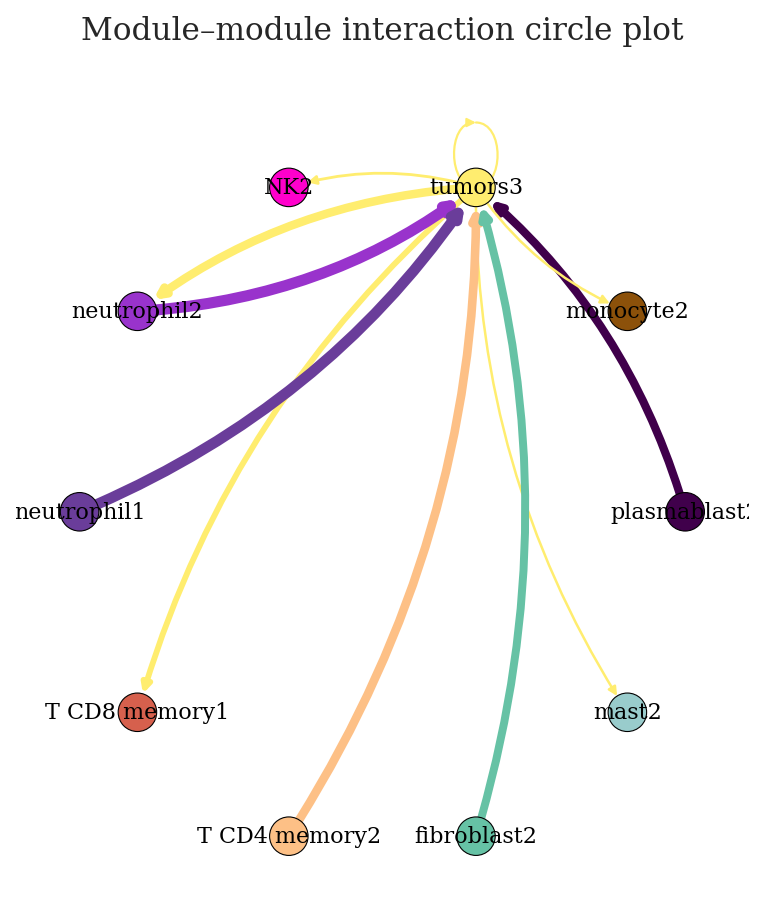

In [40]:
for ct in ["tumors" + str(i+1) for i in [0,1,2]]:

    ct_select = set(total_interactions.index[total_interactions.loc[ct,:]>0.01])
    ct_select = ct_select | set(total_interactions.columns[total_interactions.loc[:,ct]>0.01]) | {ct}
    ct_select = list(ct_select)

    ct_select = total_interactions.loc[ct_select,ct_select].copy()
    row_mask = ct_select.index.isin([ct])
    col_mask = ct_select.columns.isin([ct])

    mask = row_mask[:, None] | col_mask[None, :]
    ct_select = ct_select.where(mask, 0)

    sigmod_plot.plot_circle_interactions(ct_select.T,node_color_map,threshold = 0,
                                     edge_cmap="Reds",max_width=5,min_width=1,
                                     node_size=300,font_size=10,figsize = (5,6),
                                     file_name=f"Figures/5_2_{ct}_interactions.pdf")

## Gene Gene interaction

In [97]:
## Check whether Normalize or not
adata.X.max()

13.386517

In [12]:
cellchat = pd.read_csv("/home/liuchang/4.0_Resource/lr/human_lr_pair.txt",sep='\t')
cellchat_genes = list(cellchat.ligand_gene_symbol)

In [13]:
sigmod_beta = topic_words['fibroblast']
sigmod_beta = cci.frex(sigmod_beta.T).T
top_n_values = {}
for col in sigmod_beta.columns:
    top_n = sigmod_beta[col].nlargest(10)
    top_n_values[col] = {'values': top_n.values, 'indices': top_n.index}

top_n_values

{'fibroblast1': {'values': array([0.99112366, 0.98380757, 0.98207516, 0.98159814, 0.98058285,
         0.97007738, 0.96897601, 0.96751884, 0.96510389, 0.96495957]),
  'indices': Index(['MMP1', 'MX1', 'TWIST1', 'COL12A1', 'SOD2', 'STAT1', 'COL6A1', 'IFITM1',
         'IFI27', 'COL6A2'],
        dtype='object')},
 'fibroblast2': {'values': array([0.98537703, 0.98229056, 0.98215801, 0.98100119, 0.97161221,
         0.95943315, 0.95806754, 0.94428316, 0.94010157, 0.93360648]),
  'indices': Index(['GADD45B', 'ZFP36', 'FOS', 'MGP', 'GPX3', 'KLF2', 'SERPINA1', 'CLU',
         'LYZ', 'CFD'],
        dtype='object')},
 'fibroblast3': {'values': array([0.990625  , 0.98801836, 0.98645723, 0.98207516, 0.97980871,
         0.97968722, 0.97894947, 0.97686567, 0.97601387, 0.97343722]),
  'indices': Index(['TAGLN', 'VCAN', 'IGHG1', 'FN1', 'COL11A1', 'IGKC', 'TPM2', 'IGHG2',
         'CDH11', 'TPM1'],
        dtype='object')}}

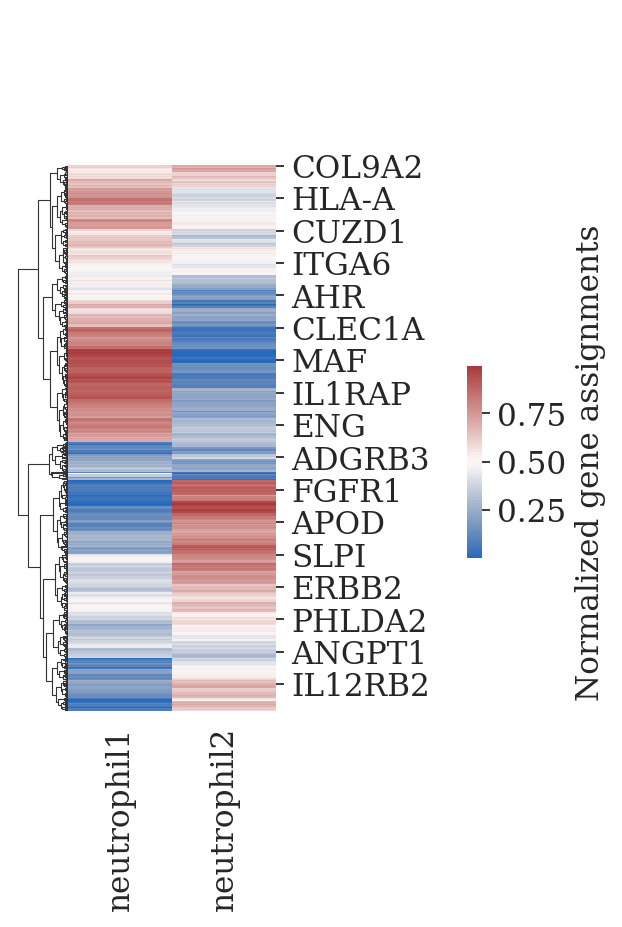

In [53]:
cg = sns.clustermap(
    sigmod_beta,
    cmap="vlag",
    center=0.5,
    # z_score=1,
    row_cluster=True,
    col_cluster=False,
    figsize=(3, 6),
    cbar_kws={'label': 'Normalized gene assignments'}
)

cg.cax.set_position([1.01, 0.40, 0.03, 0.20])

plt.show()

cg.fig.savefig(
    "./Figures/6_1_neutrophil_FREX.pdf",
    format='pdf',
    bbox_inches='tight'
)

In [ ]:
total_interactions.loc["tumors3",].sort_values()

In [101]:
import importlib
importlib.reload(cci)
importlib.reload(sigmod_plot)

<module 'SIGMOD.SIGMOD_plot' from '/home/liuchang/3.0_Result/4.0_NGDeonv/0315/LUAD/../SIGMOD/SIGMOD_plot.py'>

In [130]:
test_list, test_genes =  cci.cal_g2g(celltype_sender = ["fibroblast","plasmablast","T CD4 memory",
                                                        "neutrophil","neutrophil","tumors"
                                                      ],
                                     states_sender = ["fibroblast2","plasmablast2","T CD4 memory2",
                                                      "neutrophil1","neutrophil2","tumors3"
                                                      ], 
                                     celltype_receiver = "tumors",
                                     states_receiver = "tumors3",
                                     adata = adata,
                                     topic_words_dict = topic_words,
                                     theta_logit_dict = theta_logit,
                                     spatial_net_df = Spatial_Net,
                                     ligands = cellchat_genes,
                                     frex_=True,
                                     cutoff_r = 0.90,
                                     cutoff_s = 0.90,
                                     p_val_cutoff = 0.05)

In [131]:
test_list_subset = test_list.loc[['tumors_CXCL10', 'tumors_MX1', 'tumors_HLA-DRB1', 'tumors_MMP7', 'tumors_OAS3', 
                                  'tumors_TAP2', 'tumors_STAT1', 'tumors_TAP1','tumors_HLA-DRB5', 'tumors_NLRC5']]
test_list_subset = test_list_subset.iloc[:,1:]
test_list_subset = test_list_subset.loc[:,~test_list_subset.columns.str.contains("tumors"),]
test_list_subset = test_list_subset.loc[:,(test_list_subset.max()>0).values]

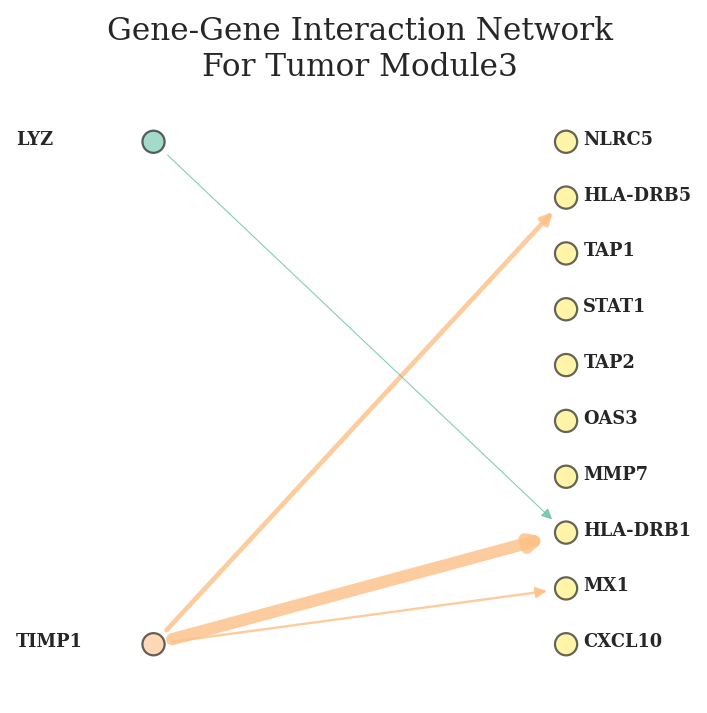

In [132]:
sigmod_plot.plot_gene_interaction_network(test_list_subset, 
                                          test_genes,
                                          node_color_map,
                                          figsize=(4, 5),
                                          title="Gene-Gene Interaction Network\nFor Tumor Module3",
                                          save_path = "./Figures/7_1_tumor3.pdf")

In [123]:
test_list, test_genes =  cci.cal_g2g(celltype_sender = ["fibroblast","tumors"
                                                      ],
                                     states_sender = ["fibroblast3","tumors2",
                                                      ], 
                                     celltype_receiver = "tumors",
                                     states_receiver = "tumors2",
                                     adata = adata,
                                     topic_words_dict = topic_words,
                                     theta_logit_dict = theta_logit,
                                     spatial_net_df = Spatial_Net,
                                     ligands = cellchat_genes,
                                     frex_=True,
                                     cutoff_r = 0.90,
                                     cutoff_s = 0.90,
                                     p_val_cutoff = 0.05)

In [124]:
test_list_subset = test_list.loc[['tumors_STMN1', 'tumors_MECOM', 'tumors_CD81', 'tumors_H4C3', 'tumors_CALM2', 
               'tumors_H2AZ1', 'tumors_ALCAM', 'tumors_HMGB2','tumors_FGFR1', 'tumors_TUBB']]
test_list_subset = test_list_subset.iloc[:,1:]
test_list_subset = test_list_subset.loc[:,~test_list_subset.columns.str.contains("tumors"),]
test_list_subset = test_list_subset.loc[:,(test_list_subset.max()>0).values]

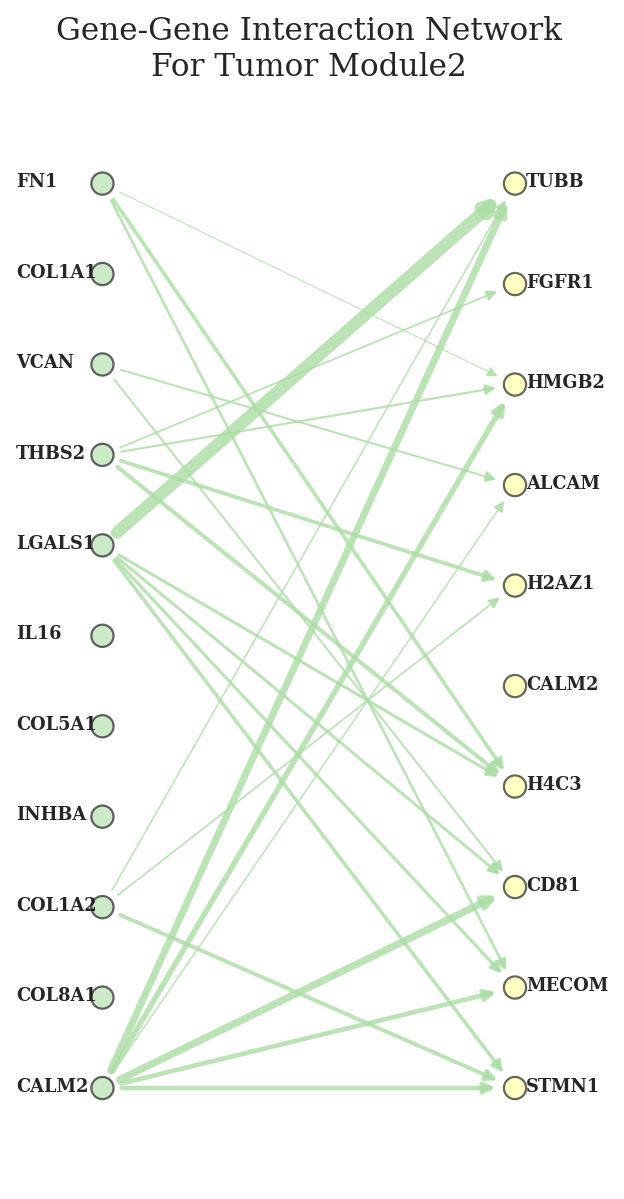

In [125]:
sigmod_plot.plot_gene_interaction_network(test_list_subset, 
                                          test_genes,
                                          node_color_map,
                                          title="Gene-Gene Interaction Network\nFor Tumor Module2",
                                          save_path = "./Figures/7_2_tumor2.pdf")

In [126]:
test_list, test_genes =  cci.cal_g2g(celltype_sender = ["neutrophil","tumors"
                                                      ],
                                     states_sender = ["neutrophil2","tumors1",
                                                      ], 
                                     celltype_receiver = "tumors",
                                     states_receiver = "tumors1",
                                     adata = adata,
                                     topic_words_dict = topic_words,
                                     theta_logit_dict = theta_logit,
                                     spatial_net_df = Spatial_Net,
                                     ligands = cellchat_genes,
                                     frex_=True,
                                     cutoff_r = 0.90,
                                     cutoff_s = 0.90,
                                     p_val_cutoff = 0.05)

In [127]:
test_list_subset = test_list.loc[['tumors_NDRG1', 'tumors_VEGFA', 'tumors_SLC2A1', 'tumors_IGFBP5', 'tumors_IGFBP3', 
                                  'tumors_SLPI', 'tumors_HILPDA','tumors_COL6A1', 'tumors_COL6A2', 'tumors_CXCL3']]
test_list_subset = test_list_subset.iloc[:,1:]
test_list_subset = test_list_subset.loc[:,~test_list_subset.columns.str.contains("tumors"),]
test_list_subset = test_list_subset.loc[:,(test_list_subset.max()>0).values]

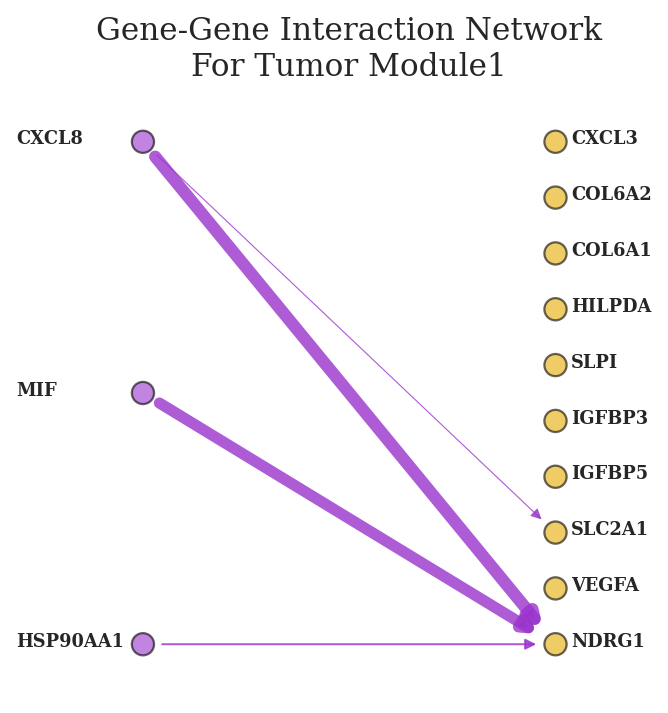

In [129]:
sigmod_plot.plot_gene_interaction_network(test_list_subset, 
                                          test_genes,
                                          node_color_map,
                                          figsize=(4, 5),
                                          title="Gene-Gene Interaction Network\nFor Tumor Module1",
                                          save_path = "./Figures/7_3_tumor1.pdf")